# Comp 6936 - Assignment 1
## Andrew Harris - 201932175
Due October 14, 2024


## Library Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from feature_gen import (word_count, character_count, chars_per_word, capital_ratio,
                         character_ratio, character_ratios, first_year, word_instances_ratios, word_instances, word_pairs)
from pygam import LinearGAM, LogisticGAM
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score


## Importing Data
The dataset is a list of financial news sentences, and a sentiment label (Positive, Negative, Neutral).

Unfortunately, PyGAM does not yet support multiclass classification. This could be remedied by using one GAM per class or by using an activation function on a regression, but these modifications would break the scope of the original assignment. For the sake of time, the 'Neutral' sentences will be removed. This will impact the real-world application of this model, but as an exploration of GAMs this should be sufficient.

In [2]:
df = (pd.read_csv("./data/data.csv")
      .rename(columns={'Sentence': 'sentence', 'Sentiment': 'sentiment'}))
df = df[df['sentiment'] != 'neutral'].reset_index(drop=True)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

df

,sentence,sentiment
0,The GeoSolutions technology will leverage Bene...,1
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",1
3,$SPY wouldn't be surprised to see a green close,1
4,Shell's $70 Billion BG Deal Meets Shareholder ...,0
...,...,...
2707,Operating profit fell to EUR 38.1 mn from EUR ...,0
2708,HSBC Says Unit to Book $585 Million Charge on ...,0
2709,Daily Mail parent company in talks with potent...,1
2710,RISING costs have forced packaging producer Hu...,0


## First Set of Features
The features for the first iteration fall into one of two categories:
### Keyword-Based Features
10 of the 16 features are based on the % of occurances of a given keyword, in comparison to the total number of words in the sentence. These keywords are:
* 'sold/sell', 'low', 'old', 'fall', 'bear'* - theoretically should occur more often on negative news
* 'buy/bought', 'high', 'new', 'grow', 'bull'* - theoretically should occur more often on positive news.

### Non Keyword-Based Features
6 of the features are based on non-keyword properties
* First Year - The first year string to occur in the sentence. For example: "It is not 20004, but 2005" -> 2005. The idea here is that news mentioning years with stock market crashes (2008, 2020) will be more negative, and years with stock market growth (1999, 2022) will be more positive.
* Word Count - The number of words in the sentence. For this we count whitespaces, so conjoined words like 'isn't' will be merged as one. Potentially positive or negative news will have different word counts, since different justifications are used for each?
* Character Count - The number of characters in the sentence. Simple enough. Same prediction logic as 'Word Count', but influenced by the length of the words themselves.
* Characters Per Word - The ratio of 'Character Count' over 'Word Count'. May pick up differences in terminology between positive/negative stories.
* Capital Ratio - The ratio of capital letter count over 'Character Count'. Negative news stories tend to be more emotionally charged, so maybe capital letters will be a good indicator?
* Dollar Sign Ratio - The ratio of '\\$' count over 'Character Count'. Many positive news stories will indicate stocks to buy (\\$APPL or \\$TSLA for example), so maybe this will be a good indicator.

The code below loads the financial news data and produces these features. Unit tests for feature generation can be found in `tests/test_feature_gen.py`.'

In [3]:
df1 = (df.copy()
       .pipe(first_year)
      .pipe(word_count)
      .pipe(character_count)
      .pipe(chars_per_word)
      .pipe(capital_ratio)
      .pipe(character_ratio, '$')
      .pipe(word_instances_ratios, [['sold', 'sell'], ['buy', 'bought'], 'low', 'high', 'new', 'old', 'grow', 'fall', 'bull', 'bear'])
      .drop(columns=['sentence']))
df1

,sentiment,first_year,word_count,character_count,chars_per_word,capital_ratio,$_ratio,word_sold_ratio,word_buy_ratio,word_low_ratio,word_high_ratio,word_new_ratio,word_old_ratio,word_grow_ratio,word_fall_ratio,word_bull_ratio,word_bear_ratio
0,1,1900,32,218,6.812500,0.059633,0.000000,0.0,0.0,0.000000,0.0,0.03125,0.000,0.0,0.0,0.0,0.0
1,0,1900,11,55,5.000000,0.090909,0.054545,0.0,0.0,0.090909,0.0,0.00000,0.000,0.0,0.0,0.0,0.0
2,1,2010,39,193,4.948718,0.056995,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000,0.0,0.0,0.0,0.0
3,1,1900,9,47,5.222222,0.063830,0.021277,0.0,0.0,0.000000,0.0,0.00000,0.000,0.0,0.0,0.0,0.0
4,0,1900,8,56,7.000000,0.142857,0.017857,0.0,0.0,0.000000,0.0,0.00000,0.125,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,0,2007,14,63,4.500000,0.111111,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000,0.0,0.0,0.0,0.0
2708,0,1900,10,56,5.600000,0.178571,0.017857,0.0,0.0,0.000000,0.0,0.00000,0.000,0.0,0.0,0.0,0.0
2709,1,1900,18,133,7.388889,0.105263,0.007519,0.0,0.0,0.000000,0.0,0.00000,0.000,0.0,0.0,0.0,0.0
2710,0,1900,17,107,6.294118,0.074766,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000,0.0,0.0,0.0,0.0


## Evaluation of Current GAM
First, let's explore the class balance to see which performance metric would work best.

<Axes: xlabel='sentiment'>

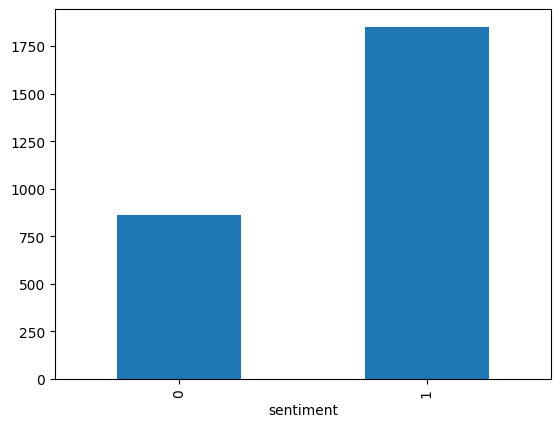

In [4]:
df1.groupby('sentiment').count()['first_year'].plot(kind='bar')

The classes are unbalanced, with more than 2x the number of positive instances versus negative instances. Therefore I will use f1 scores, which excel in the case of imbalanced data. Lets evaluate the current feature set with a GAM, using 5-fol cross-validation for scoring.

In [5]:
df_X = df1.drop(['sentiment'], axis=1).values
df_y = df1['sentiment']

def create_gam(X: np.ndarray, y: np.ndarray) -> LinearGAM:
    # The splines in the GAM are trained with a penalty term which is varied by these 'lam' values. The
    # higher these values, the smoother the resulting spline is.
    lams = np.random.rand(250, X.shape[1])
    lams = lams * 4 - 2
    lams = np.exp(lams)
    
    # Searching the entire space of lambda values would be difficult, so we will perform a randomized
    # grid search over 150 sampled values
    gam = LogisticGAM(n_splines=8).gridsearch(X, y, lam=lams)
    
    return gam

kf = KFold(n_splits=5)
results = []
for i, (train_index, test_index) in enumerate(kf.split(df_X)):
    gam = create_gam(df_X[train_index], df_y[train_index])
    pred = gam.predict(df_X[test_index])
    
    # In most f1 scoring cases the positive class is rarer. In our case the class imbalancement is opposite (more positive instances), 
    # so the ignored True Negative values make up a majority of the predictions.
    # For the sake of scoring we will flip this so the True Positives are ignored instead.
    results.append(f1_score(df_y[test_index].values, pred, pos_label=0))

scores = [np.array(results)]
(scores[0].mean(), scores[0].std())

100% (250 of 250) |######################| Elapsed Time: 0:01:34 Time:  0:01:340107
100% (250 of 250) |######################| Elapsed Time: 0:01:33 Time:  0:01:331507
100% (250 of 250) |######################| Elapsed Time: 0:01:31 Time:  0:01:310107
100% (250 of 250) |######################| Elapsed Time: 0:01:30 Time:  0:01:300107
100% (250 of 250) |######################| Elapsed Time: 0:01:33 Time:  0:01:330107


(0.23449048900217123, 0.028840382469657738)

The accuracy score is around 0.23, which is very poor. Let's explore the individual feature splines to see if we can do better.

## Plotting Learned GAM Splines
First, let's train our GAM on all the available data:

In [6]:
df_X = df1.drop(['sentiment'], axis=1).values
df_y = df1['sentiment']

gam1 = create_gam(df_X, df_y)
gam1

100% (250 of 250) |######################| Elapsed Time: 0:01:37 Time:  0:01:370108


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + intercept,
   tol=0.0001, verbose=False)

## Plotting Splines
The learned function for each feature will be plotted on a 4x4 grid for comparison.

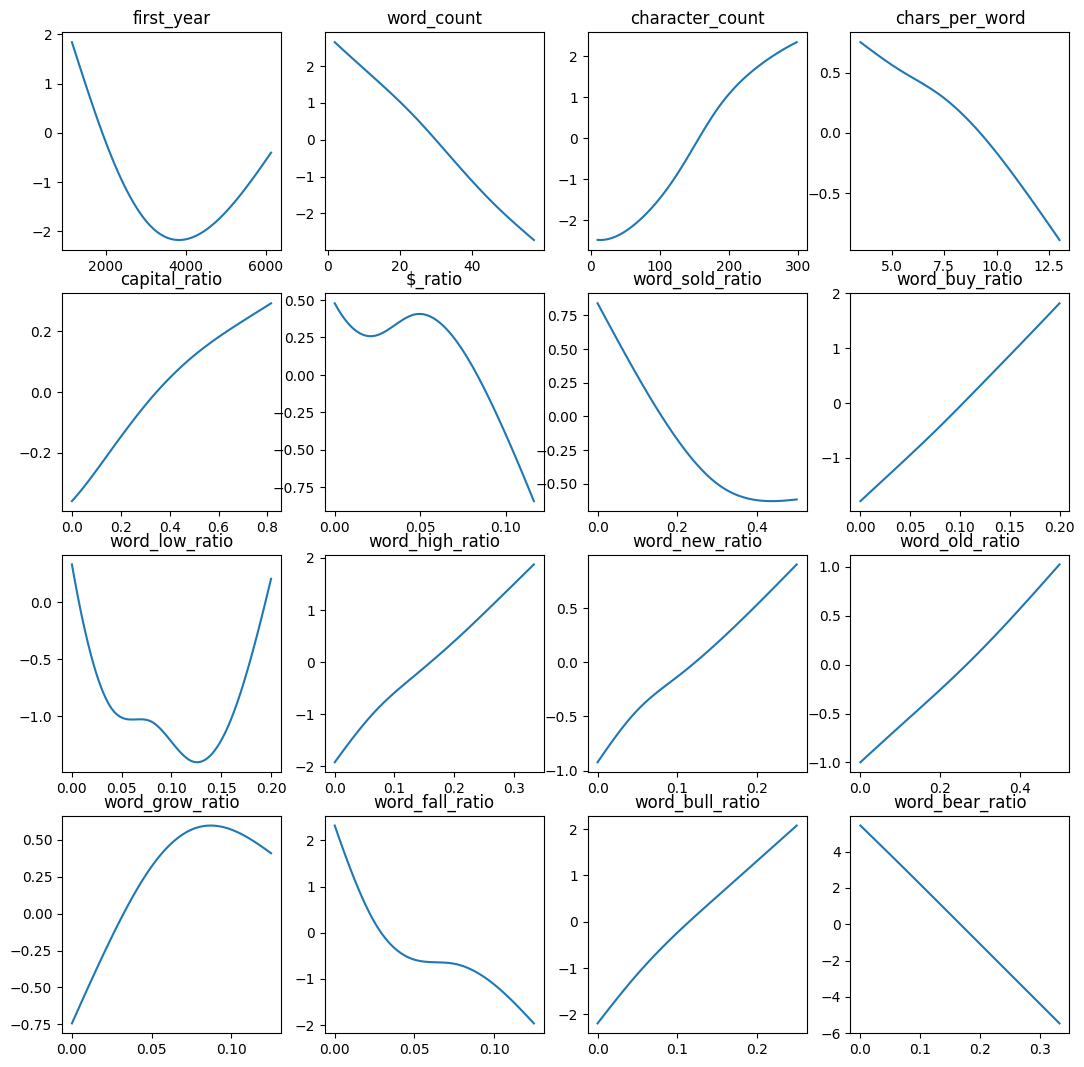

In [7]:
titles = df1.drop(['sentiment'], axis=1).columns
fig, ax = plt.subplots(4, 4, figsize=(13, 13))

for i, x in enumerate(ax.flatten()):
    XX = gam1.generate_X_grid(term=i)
    x.plot(XX[:, i], gam1.partial_dependence(term=i, X=XX))
    x.set_title(titles[i])

plt.show()

From these plots, we can make some subjective judgements about which features could be replaced:

First, itt seems that the first_year feature is not very successful, the range is much larger than the expected ~1950-2030 value ranges. This feature should be replaced.

All other features seem to have a general trend (no horizontal lines), only differing in y-magnitudes. We can replace some of the features with weaker correlations, such as:
1. $_ratio
2. capital_ratio
3. Keyword ratios such as: 'grow', 'low', 'sold', 'new', 'old'.
4. chars_per_word

With these removed, we now need to make 9 new features to replace them.



## Feature Iteration 2
The second feature set iteration will include these 7 features from the previous iteration:
* word_count
* character_count
* word_buy_ratio
* word_high_ratio
* word_fall_ratio
* word_bull_ratio
* word_bear_ratio

In addition to these, we will experiment with different features in three categories:
1. Three new features will be added as keyword ratios like last time, this time with 'forecast', 'surprise', and 'poor'. 'forecast' may indicate a positive prediction for the future, where 'surprise' and 'poor' may occur more frequently in negative news.
2. Three dual-keyword features, 'high/low', 'new/old', 'good/bad'. Any occurrence of the positive keyword will add +1 to the feature, any occurrence of the negative keyword will add -1 to the feature. This is divided by the total number of words in the sentence. This feature works since each pair of words are the opposite of each other, so this may correlate better with a negative/positive sentiment.
3. Features counting the number of question marks in the sentence. This symbol may be more correlated with negative news.

In [8]:
df2 = (df.copy()
      .pipe(word_count)
      .pipe(character_count)
      .pipe(character_ratios, ['?'])
      .pipe(word_instances_ratios, [['buy', 'bought'], 'high', 'fall', 'bull', 'bear', 'forecast', 'surprise', 'poor'])
      .pipe(word_pairs, [['low', 'high'], ['old', 'new'], ['bad', 'good']])
      .pipe(word_instances, ['grow', 'sold'])
      .drop(columns=['sentence']))
df2

,sentiment,word_count,character_count,?_ratio,word_buy_ratio,word_high_ratio,word_fall_ratio,word_bull_ratio,word_bear_ratio,word_forecast_ratio,word_surprise_ratio,word_poor_ratio,lowhigh_word_pair,oldnew_word_pair,badgood_word_pair,word_grow_count,word_sold_count
0,1,32,218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.03125,0.0,0,0
1,0,11,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.090909,0.00000,0.0,0,0
2,1,39,193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0,0
3,1,9,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.00000,0.0,0,0
4,0,8,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-0.12500,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,0,14,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0,0
2708,0,10,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0,0
2709,1,18,133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0,0
2710,0,17,107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0,0


Now, we can re-evaluate our performace to see if it has improved:

In [9]:
df_X = df2.drop(['sentiment'], axis=1).values
df_y = df2['sentiment']

kf = KFold(n_splits=5)
results = []
for i, (train_index, test_index) in enumerate(kf.split(df_X)):
    gam = create_gam(df_X[train_index], df_y[train_index])
    pred = gam.predict(df_X[test_index])
    
    results.append(f1_score(df_y[test_index].values, pred, pos_label=0))

scores.append(np.array(results))
(scores[1].mean(), scores[1].std())

100% (250 of 250) |######################| Elapsed Time: 0:01:34 Time:  0:01:340107
100% (250 of 250) |######################| Elapsed Time: 0:01:42 Time:  0:01:420108
100% (250 of 250) |######################| Elapsed Time: 0:01:34 Time:  0:01:340107
100% (250 of 250) |######################| Elapsed Time: 0:01:34 Time:  0:01:340107
100% (250 of 250) |######################| Elapsed Time: 0:01:39 Time:  0:01:390108


(0.23522639742134852, 0.025735109726948577)

Unfortunately it seems like our score is similar to last time, only marginally increasing. Let's explore some of the new feature splines.

100% (250 of 250) |######################| Elapsed Time: 0:01:39 Time:  0:01:390108


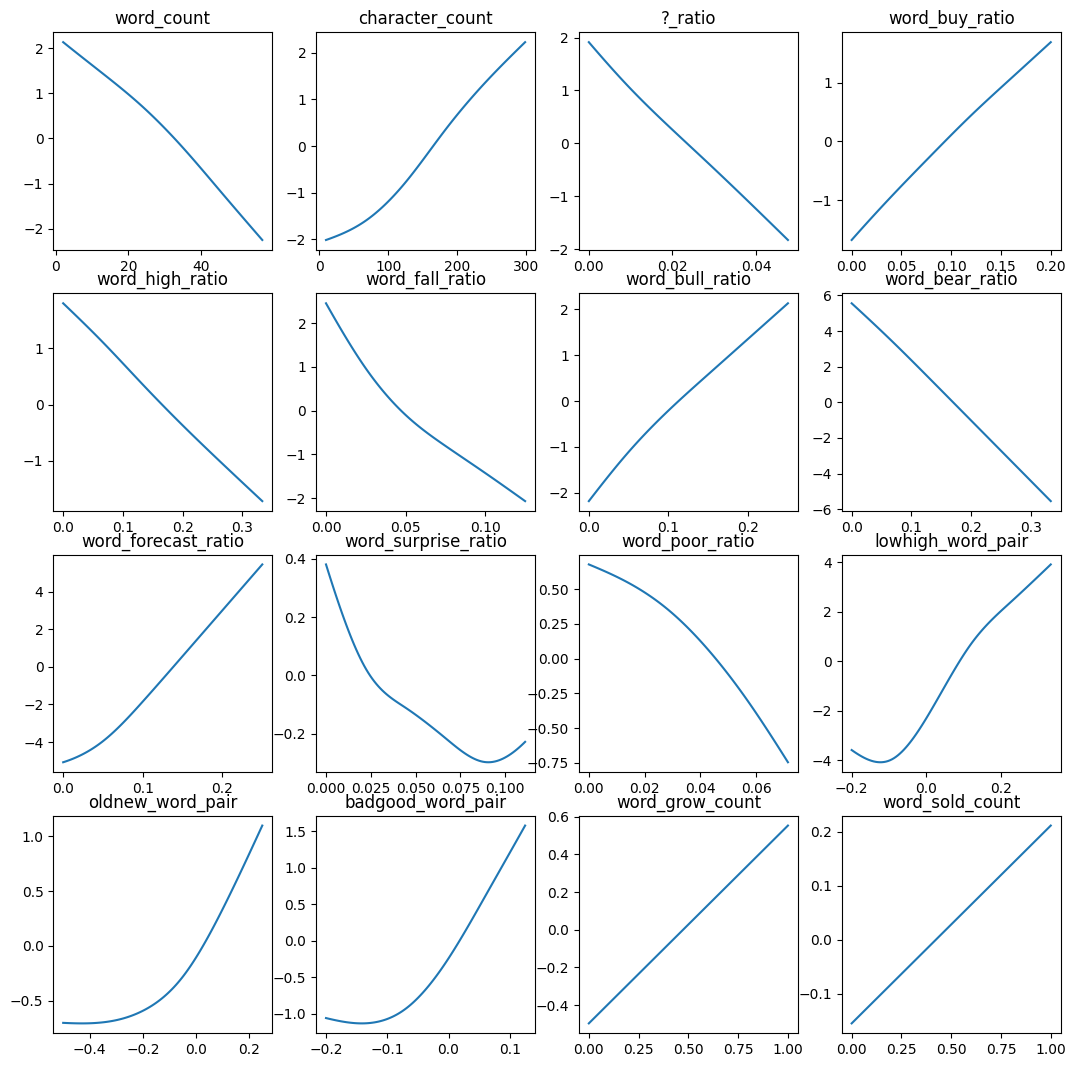

In [10]:
df_X = df2.drop(['sentiment'], axis=1).values
df_y = df2['sentiment']

gam2 = create_gam(df_X, df_y)
titles = df2.drop(['sentiment'], axis=1).columns
fig, ax = plt.subplots(4, 4, figsize=(13, 13))

for i, x in enumerate(ax.flatten()):
    XX = gam2.generate_X_grid(term=i)
    x.plot(XX[:, i], gam2.partial_dependence(term=i, X=XX))
    x.set_title(titles[i])

plt.show()

Again, we can make some selections based on the properties of each learned spline. Each one shows a distinguished trend, so we can use the y magnitudes again to make some replacement decisions. Based on these magnitudes, we will remove:
* word_sold_count & word_grow_count
* word_surprise_ratio & word_poor_ratio
* oldnew_word_pair & badgood_word_pair

We seem to have success with the low/high word pair, even when the individual low & high keyword features didn't perform as well. With this in mind, let's combine bull & bear into a pair feature for the next featureset. We can do the same with the buy & high keywords, in favour of buy/sell & high/low.


## Featureset Iteration #3
This featureset will contain these features from the previous set:
* word_count & character_count
* ?_ratio
* word_fall_ratio & word_forecast_ratio
* lowhigh_word_pair

The following word pairs will be added to replace pre-existing keyword features:
* bull/bear
* grow & grew/fall & fell

The remaining eight features will come from the following:
* '.', '%' and '!" ratios. The ?_ratio feature seemed to work well, so lets try this with different punctuation.
* More word pairs such as buy & bought/sell & sold, positive/negative, up/down, long/short. Maybe using word pairs will help reveal patterns that individual keywords couldn't?
* 'change' as a keyword. This is more of a gamble, maybe news indicating changes in a business will indicate negative sentiment?

In [11]:
df3 = (df.copy()
      .pipe(word_count)
      .pipe(character_count)
      .pipe(character_ratios, ['?', '.', '%', '!'])
      .pipe(word_instances_ratios, ['fall', 'forecast', 'change'])
      .pipe(word_pairs, [['low', 'high'], 
                         ['bear', 'bull'], 
                         [['fall', 'fell'], ['grow', 'grew']], 
                         [['sell', 'sold'], ['buy', 'bought']],
                         ['negative', 'positive'],
                         ['down', 'up'],
                         ['short', 'long']])
      .drop(columns=['sentence']))
df2

,sentiment,word_count,character_count,?_ratio,word_buy_ratio,word_high_ratio,word_fall_ratio,word_bull_ratio,word_bear_ratio,word_forecast_ratio,word_surprise_ratio,word_poor_ratio,lowhigh_word_pair,oldnew_word_pair,badgood_word_pair,word_grow_count,word_sold_count
0,1,32,218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.03125,0.0,0,0
1,0,11,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.090909,0.00000,0.0,0,0
2,1,39,193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0,0
3,1,9,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.00000,0.0,0,0
4,0,8,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,-0.12500,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,0,14,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0,0
2708,0,10,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0,0
2709,1,18,133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0,0
2710,0,17,107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0,0


And now, let's get a final accuracy score for this last featureset:

In [12]:
df_X = df3.drop(['sentiment'], axis=1).values
df_y = df3['sentiment']

kf = KFold(n_splits=5)
results = []
for i, (train_index, test_index) in enumerate(kf.split(df_X)):
    gam = create_gam(df_X[train_index], df_y[train_index])
    pred = gam.predict(df_X[test_index])
    
    results.append(f1_score(df_y[test_index].values, pred, pos_label=0))

scores.append(np.array(results))
(scores[2].mean(), scores[2].std())

100% (250 of 250) |######################| Elapsed Time: 0:01:42 Time:  0:01:420108
100% (250 of 250) |######################| Elapsed Time: 0:01:34 Time:  0:01:340107
100% (250 of 250) |######################| Elapsed Time: 0:01:47 Time:  0:01:470109
 12% (30 of 250) |##                     | Elapsed Time: 0:00:19 ETA:   0:02:24

did not converge


 44% (112 of 250) |#########             | Elapsed Time: 0:01:04 ETA:   0:01:20

did not converge


100% (250 of 250) |######################| Elapsed Time: 0:02:05 Time:  0:02:050110
 38% (97 of 250) |########               | Elapsed Time: 0:00:49 ETA:   0:01:17

did not converge


100% (250 of 250) |######################| Elapsed Time: 0:01:52 Time:  0:01:520109


(0.4791915035036734, 0.05231622534700351)

Those changes to the featureset seem to make a significant difference in the f1-score. For completeness, here are the learned splines for each feature.

100% (250 of 250) |######################| Elapsed Time: 0:01:50 Time:  0:01:500109


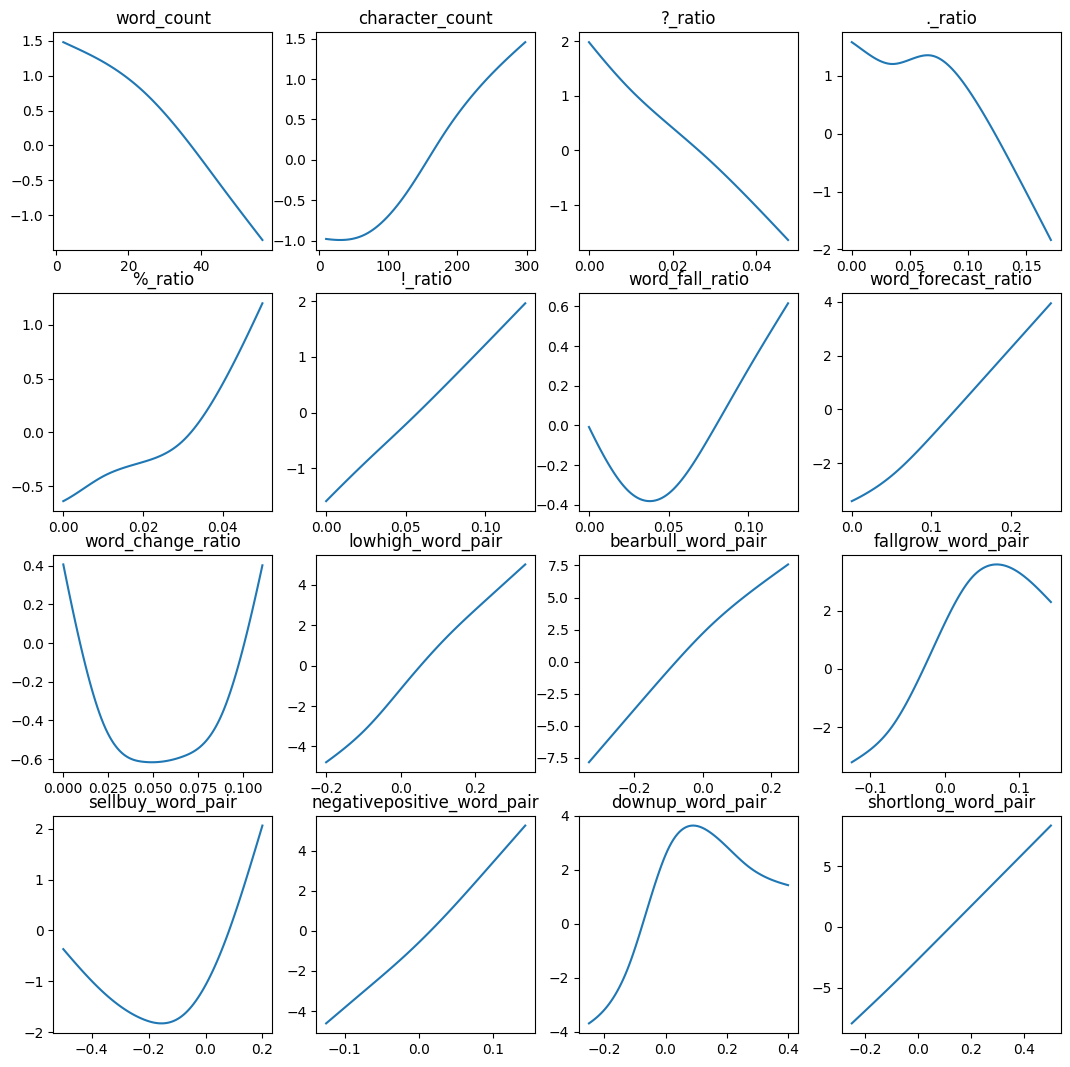

In [13]:
df_X = df3.drop(['sentiment'], axis=1).values
df_y = df3['sentiment']

gam3 = create_gam(df_X, df_y)
titles = df3.drop(['sentiment'], axis=1).columns
fig, ax = plt.subplots(4, 4, figsize=(13, 13))

for i, x in enumerate(ax.flatten()):
    XX = gam3.generate_X_grid(term=i)
    x.plot(XX[:, i], gam3.partial_dependence(term=i, X=XX))
    x.set_title(titles[i])

plt.show()

The word pair features seem to have done the trick, with each one contributing a good amount to the overall prediction. If I were to do another iteration I would introduce more of these pairs, replacing the remaining keyword features & some of the underperforming character features ('%' and '.').

## Conclusion

Overall, we have seen that the individual feature plots of GANs can offer invaluable insights to the performance of individual features. Over three iterations of featuresets, the f1 score improved like so:

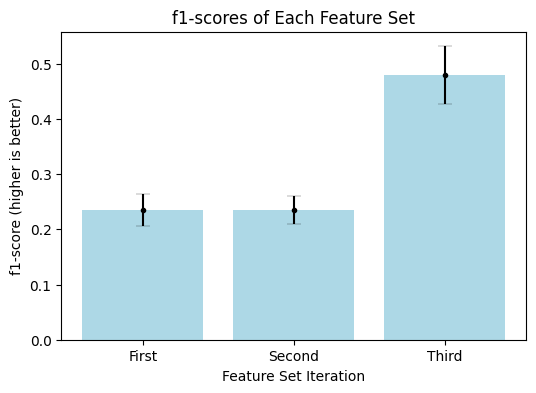

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))

final_scores = np.array(scores)
x = ['First', 'Second', 'Third']

ax.bar(x, final_scores.mean(axis=1), color='lightblue')
ax.errorbar(x, final_scores.mean(axis=1), yerr=final_scores.std(axis=1), fmt='.', color='black', capsize=5, capthick=0.2)
ax.set_title("f1-scores of Each Feature Set")
ax.set_ylabel("f1-score (higher is better)")
ax.set_xlabel("Feature Set Iteration")

plt.show()

The f1 scores are still poor even with the best iteration, which may indicate that GAMs may not be a good fit for this problem in terms of performance. However, the performance improvement does illustrate the ability of GAMs to assist with feature engineering.